### Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

### Data

In [2]:
df = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name = 1)

df = df.set_index('date')

df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


In [3]:
log_df = np.log(1 + df)

log_df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0339,0.0026
1926-03-31,-0.0594,0.0026
1926-04-30,0.0378,0.0023
1926-05-28,0.0135,0.0027


## 1. Historic VaR
### (a) Plot $\tilde{r}^{VaR, .05}_{t, historic}$ over time

In [128]:
level_excess = df["SPX"] - df["TB1M"]
level_excess.dropna(inplace=True)

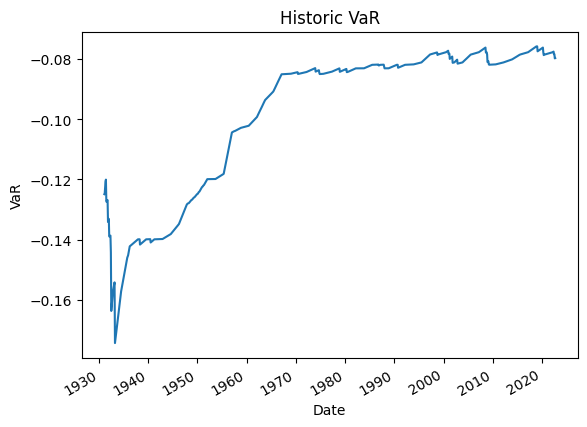

In [129]:
historic_VaR = level_excess.shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()

plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

### (b) Calculate the frequency of periods in which $\tilde{r_{t}} < \tilde{r}^{VaR, .05}_{t, historic}$ 

In [130]:
historic_VaR = level_excess.shift().expanding(min_periods=60).quantile(.05)
round(sum(level_excess < historic_VaR)/len(historic_VaR.dropna()), 4)

0.0303

### (c)What drawbacks do you see in this historic VaR
- By definition of VaR, number instances of return should be less than VaR (5%) should be close to 5%, but in our case it is 3%
- This method of calculation is valid if there is a smooth tail, and does not give correct result if tails are not smooth

## 2. Volatility
### (a) For each of these three methods, plot σt. (Plot the vol, not the variance.)

In [131]:
expanding_vol = np.sqrt((level_excess**2).shift().expanding(min_periods=60).mean())
rolling_vol = np.sqrt((level_excess**2).shift(1).rolling(window=60).mean())
vol_data = pd.DataFrame()
vol_data["expanding_vol"] = expanding_vol
vol_data["rolling_vol"] = rolling_vol

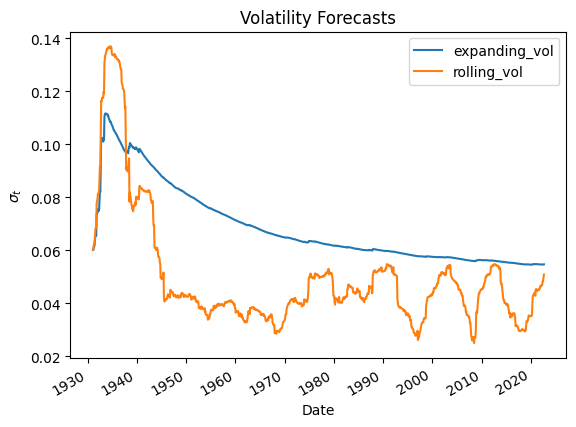

In [132]:
vol_data.dropna()

vol_data.plot()
plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

### (b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight sim- plification of the normal VaR formula, by dropping μ from that formula, and rounding the normal distribution z-score to -1.65.

In [133]:
VaR = -1.65 * vol_data.dropna()
VaR.columns = ["expanding", "rolling"]
VaR.head()

,expanding,rolling
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043


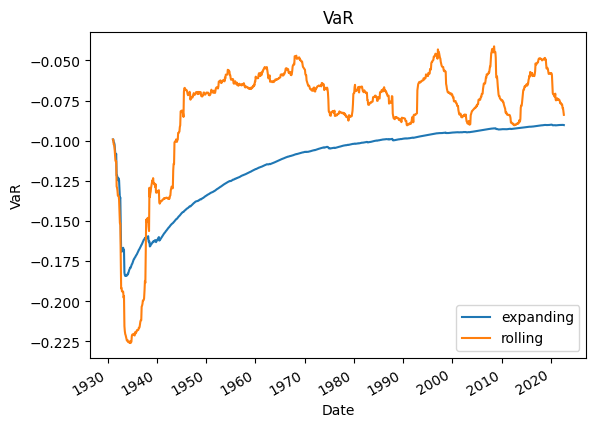

In [134]:
VaR.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

### (c) For each of these three vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r_{t}} < \tilde{r}^{VaR, .05}_{t, vol}$

In [135]:
u_data = level_excess.iloc[60:, ]

freq_data = pd.DataFrame(index=['Frequency'], columns=VaR.columns)
n = len(VaR)
for col in VaR.columns:
    freq_data[col] = len(u_data[u_data < VaR[col]])/n

freq_data

,expanding,rolling
Frequency,0.0175,0.0496


### (d) Compare and contrast your results among each other and relative to the historic method in the previous problem.in the previous problem.
* By using expanding window, we calculated the frequency is 0.017, which is much smaller than 0.05, and by using rolling window, the result is much close to 0.05
* By using expanding window, volatility is convergent to some certain level

## 3. CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for q = .05.) That is, calculate CVaR for
### (a) the empirical cdf

In [136]:
CVaR = pd.Series(index=historic_VaR.index[60:])
for ind in CVaR.index:
    _d = level_excess.shift().loc[:ind]
    CVaR.loc[ind] = _d[_d < historic_VaR.loc[ind]].mean()

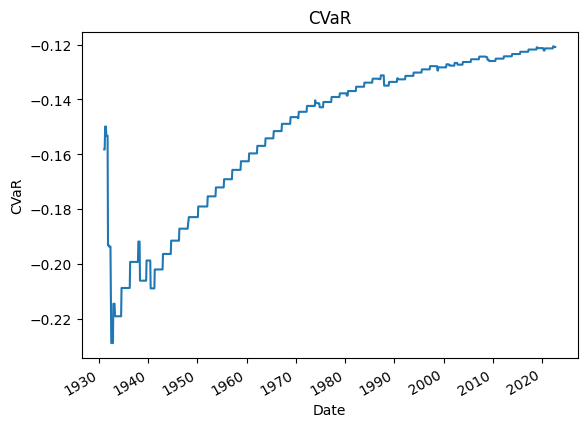

In [137]:
CVaR.plot()

plt.title('CVaR')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

### (b) the normal model, using expanding volatility estimates

In [154]:
expanding_mu = level_excess.shift().expanding(min_periods=60).mean()
expanding_vol = np.sqrt((level_excess**2).shift().expanding(min_periods=60).mean())
# fi = (historic_VaR - expanding_mu)/expanding_vol
fi_no_mu = - expanding_mu/expanding_vol
# CVaR = pd.DataFrame(stats.norm.cdf(fi), columns=["CVaR: normal model: expanding vol"])
CVaR = pd.DataFrame(stats.norm.cdf(fi_no_mu), columns=["CVaR: normal model: expanding vol: mu=0"])
CVaR["CVaR: normal model: expanding vol: -1.65vol"] = stats.norm.cdf(-1.65*expanding_vol)


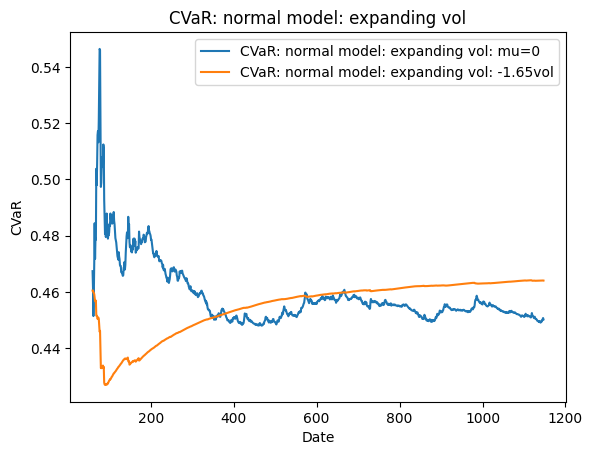

In [155]:
CVaR.plot()

plt.title('CVaR: normal model: expanding vol')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

### (b) the normal model, using expanding volatility estimates

In [158]:
rolling_mu = level_excess.shift().rolling(60).mean()
rolling_vol = np.sqrt((level_excess**2).shift().rolling(60).mean())
fi = - rolling_mu/rolling_vol
CVaR = pd.DataFrame(stats.norm.cdf(fi), columns=["CVaR: normal model: rolling vol: mu=0"])
CVaR["CVaR: normal model: rolling vol: -1.65vol"] = stats.norm.cdf(-1.65*rolling_vol)

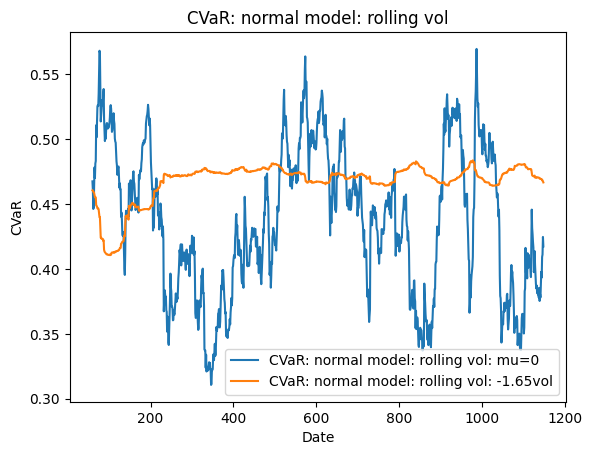

In [159]:
CVaR.plot()

plt.title('CVaR: normal model: rolling vol')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

## 4. Extra
#### Exponentially Weighted Moving Average (EWMA)

In [68]:
IGARCH = arch_model(level_excess)

theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 3984570.5364937778
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1858.8039187809004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1858.8039187817976
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.007
Name: params, dtype: float64

In [69]:
GARCH = arch_model(level_excess, vol='Garch',
                   p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params


Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95951727
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          7.8426e-03
omega       5.8962e-05
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

In [71]:
stdev = vol_data.copy()
stdev[['GARCH', 'EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0, 2:] = 0.15

### Simulate the rest of the period using the initial stdev given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta
                                    + (1-theta)*(level_excess[i-1]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega']
                                     + (stdev['GARCH'].iloc[i-1]**2) *
                                     GARCH_model.params['beta[1]']
                                     + GARCH_model.params['alpha[1]']*(level_excess[i-1]**2))


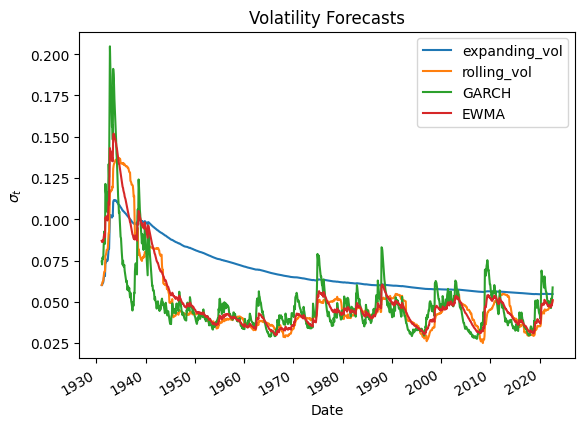

In [72]:
stdev.dropna(inplace=True)

stdev.plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

# 3. Estimating Underperformance
## 1. Summary Statistics
### (a) Report the following (annualized) statistics.

In [39]:
def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = [r'log $r^{M}$',r'log ${\tilde{r}^{M}}$',r'log $r^{f}$'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + " mean"] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + " mean"] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + " vol"] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + " vol"] *= np.sqrt(annual_factor)
    
    return df

def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

In [40]:
stats_ = join([annualized_stats(df.loc['1965':'1999'], 12),
             annualized_stats(df.loc['2000':'2022'], 12),
             annualized_stats(df.loc['1926':'2022'], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':'2022'], 12, log = True),
                 annualized_stats(log_df.loc['1926':'2022'], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

,1965-1999 mean,1965-1999 vol,2000-2022 mean,2000-2022 vol,1926-2022 mean,1926-2022 vol
$r^{M}$,0.1294,0.1494,0.0759,0.1526,0.1135,0.1874
${\tilde{r}^{M}}$,0.0679,0.1502,0.0616,0.1531,0.0819,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log $r^{M}$,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log ${\tilde{r}^{M}}$,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log $r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


In [50]:
pd.DataFrame(stats_df.values, columns=pd.MultiIndex.from_product(
                 [["1965-1999", "2000-2022", "1926-2022"], ["mean", "vol"]]),
                 index=pd.MultiIndex.from_product( [['levels', 'logs'], [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$']]))

1965-1999         2000-2022         1926-2022        
                              mean     vol      mean     vol      mean     vol
levels $r^{M}$              0.1294  0.1494    0.0759  0.1526    0.1135  0.1874
       ${\tilde{r}^{M}}$    0.0679  0.1502    0.0616  0.1531    0.0819  0.1881
       $r^{f}$              0.0615  0.0072    0.0143  0.0050    0.0315  0.0086
logs   $r^{M}$              0.1176  0.1496    0.0640  0.1537    0.0957  0.1867
       ${\tilde{r}^{M}}$    0.0563  0.1504    0.0497  0.1542    0.0642  0.1873
       $r^{f}$              0.0613  0.0071    0.0143  0.0050    0.0315  0.0085

### (b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.
**(1)compare different sample returns:**
* For both level and log absolute returns, full sample returns are lower than 1965-1999 returns, higher than 2000-2022 returns. 1965-1999 outpreformed full-sample, however 2000-2022 underpreformed full-sample returns. 
* For excess returns, full sample outpreformed both earlier and 2000-2022 returns due to the notable decrease in risk-free rate. 

**(2)compare level returns and log returns:**
* The log returns show lower mean returns as expected.

## 2. Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return.

$$\Pr [R^M_{t, t+h} < R^f_{t, t+h} ]$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

### (a) Calculate (1) using the subsample 1965-1999.

In [51]:
def prob_calc(h, rf, tilde_mu, tilde_sigma):
    return stats.norm.cdf((rf - tilde_mu) / (tilde_sigma / np.sqrt(h)))

def prob(h, rf, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], rf, tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [52]:
mu_tilde = stats_df.iloc[4, 0]
sigma_tilde = stats_df.iloc[4, 1]
# mu_tilde = stats_df.iloc[3, 0]
# sigma_tilde = stats_df.iloc[3, 1]
h = 1999 - 1965

prob([h], 0.0, mu_tilde, sigma_tilde)

,Probability
h,
34,0.0146


### (b) Report the precise probability for h = 10 and h = 30 years.

In [53]:
prob([10, 30], 0.0, mu_tilde, sigma_tilde)

,Probability
h,
10,0.1183
30,0.0202


### (c) Plot the probability as a function of the investment horizon, h, for 0 < h ≤ 30 years.


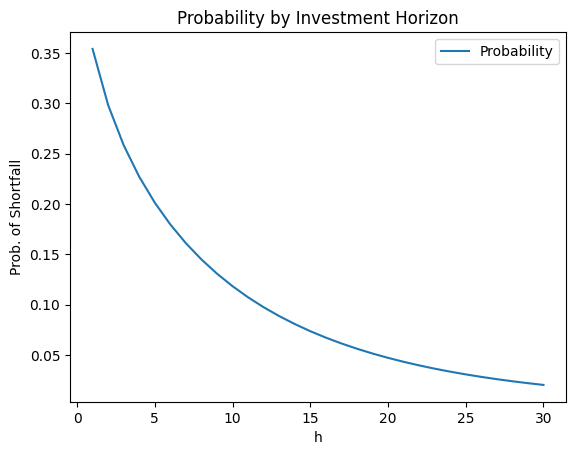

In [54]:
prob_horizon = prob(list(range(1, 31)), 0.0, mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

## 3. How different are the long-run probabilities now considering this extra data?
* formal long-run prob 0.0202, with this extra data, prob 0.0253, the probabilities increase, but a little. 

In [61]:
log_df1965 = log_df.loc['1965':'2022',].dropna()
mu_tilde_n = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde_n = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

In [62]:
prob([30], 0, mu_tilde_n, sigma_tilde_n)

,Probability
h,
30,0.0253


In [59]:
prob_horizon1 = prob(list(range(1, 31)), 0.0, mu_tilde, sigma_tilde)
prob_horizon2 = prob(list(range(1, 31)), 0.0, mu_tilde_n, sigma_tilde_n)
prob_horizon = pd.merge(prob_horizon1, prob_horizon2, left_index=True, right_index=True)
prob_horizon.columns = ["1965-1999", "1965-2022"]

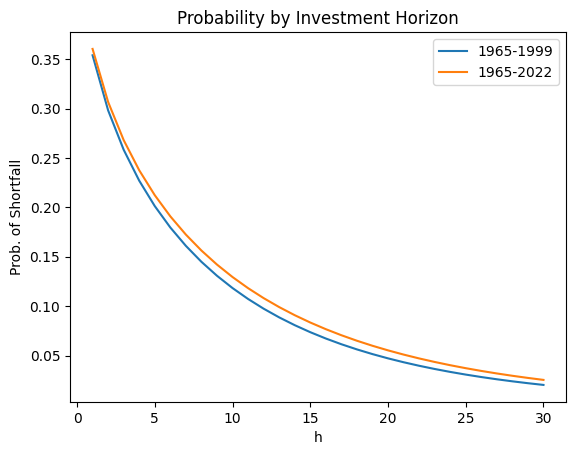

In [60]:
prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

## 4. Let’s consider how things turned out relative to Barnstable’s 1999 expectations.
### (a) 
**What was the probability (based on the 1999 estimate of μ,) that the 21-year market return, $R^M_{t, t+21}$ , would be smaller than that realized in 2000-2022? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for σ.**

In [110]:
c = stats_df.iloc[3, 2]  # mean of 2000-2022

mu = stats_df.iloc[3, 0]   # mean of 1965-1999, the 1999 estimate of mu
sigma = stats_df.iloc[3, 1]    # std of 1965-1999
h = 22

prob([h], c, mu, sigma)

,Probability
h,
22,0.0852


### (b) 
**Suppose Barnstable had implemented the put-option strategy with the growing strike of 6%? Based on the 2000-2022 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of μ, σ to be the estimates based on 1965-2022.**

For estimated calculate return $Z$, $Z \sim N(\mu_{65}, \sigma_{65}^2)$, which satisfied the following equation:

$$\Pr [R^M_{t, t+h} < log(1+strike_{growth}) ]$$

where, $h=30$

$$R^M_{t, t+h} = \frac{22\mu_{20}+8*Z}{30}$$

which means the expected return of stock is lower than that of strike

In [67]:
strike = np.log(1.06)

mu65 = log_df1965['SPX'].mean() * 12
sigma65 = log_df1965['SPX'].std() * np.sqrt(12)
rf = (30*strike - 22*stats_df.iloc[3, 2])/8
prob([8], rf, mu65, sigma65)

,Probability
h,
8,0.1539
